# Modelling the number of COVID-19 infectants using a modified SIR model

**CHE 116: Numerical Methods and Statistics**

**Professor: Andrew White** 

# Abstract

The purpose of this project predicting the number of COVID-19 infectants globally using a modified version of the SIR model. The hypothesis of this project is that this model provides an accurate prediction of the number of infectants. This can be proved that by correlating the predictions to the real-life data about virus.   

Statistical analysis was done one the predictions to prove  the hypothesis. First, since linear regression is used to improve the output of the model, one of the assumptions is that the noise is normally distributed. So, by histogramming and doing a Shapiro-Wilk test the normality of the residuals can be tested. Second, the regression model is also justified using a spearman correlation test. Third, to test how far off the fitted value from the actual value, the standard error of residuals is calcualted. 

# SIR model

The SIR model is a simple compartmental model that is used in epidemiology for modelling the spread of an infectious disease. This model divides a fixed population into three compartments, each change as a function of time. Figure(1) shows the three compartments of the model where the susceptibles are those who have not been infected yet, and the Removed are both those who recovered and died after being infected.   
The two parameters of the model are β and γ. β is the average contact rate of the disease. γ is the rate of recovery or mortality. 
![](https://i.ibb.co/ZNm3VTk/SIR.png)  
$$ Fig (1)$$

**The differential equations used for modelling are:** [1]

$$ \frac {dS}{dt} = \frac{-β \times S \times I}{N}$$   
$$ \frac {dI}{dt} = \frac{β \times  S \times I}{N} - γ \times I $$   
$$ \frac {dR}{dt} = γ \times I $$  

**Parameter Estimation:**    

This project models the number of COVID-19 infectants starting from March 30, 2020 to May 13, 2020. The model parameters,β and γ, can be estimated from the epidemic data, obtained from John's Hopkins data repository[2], before the start date of modelling. By manipulating the differential equations above.   

Parameter estimation is a key to the accuracy of the model predictions. β and γ values change over time, but in the model they are kept as constants which creates devitions between the model outcomes and real-life data. A small  prediction interval of 14-days was chosen to minimize this error. 


In [ ]:
The following code obtaines the data

In [43]:
import pandas as pd
import math 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import scipy.stats as ss
import scipy.linalg as linalg
import datetime as dt
%matplotlib inline 

In [44]:
# Obtaining Infectants Data
infected=pd.read_csv("time_series_covid19_confirmed_global.csv")

df_1=infected.groupby("Country/Region").sum()

temp=df_1.iloc[170,].index.tolist()

# print(temp.index("4/13/20"))
I = df_1.iloc[:,70:71].sum().values[0]
#print(I)
I_sum= (df_1.iloc[:,2:71].sum()).sum()
#print(I_sum)

In [45]:
# Obtaining Recovered Data
recovered= pd.read_csv("time_series_covid19_recovered_global.csv")

df=recovered.groupby("Country/Region").sum()

R= df.iloc[:,70:71].sum().values[0]
#print (R)
R_sum= (df.iloc[:,2:71].sum()).sum()
#print(R_sum)

In [46]:
# Obtaining Death Data
death= pd.read_csv("time_series_covid19_deaths_global.csv")
df_2=death.groupby("Country/Region").sum()

D= df_2.iloc[:,70:71].sum().values[0]
# print (D)
D_sum = (df_2.iloc[:,2:71].sum()).sum()
# print(D_sum)

In [47]:
# Romoved Population  
# DR refers to death and recovery number combined
DR= D + R 
# print(DR)
DR_sum= D_sum +R_sum
# print(DR_sum)

The following code estimates the parameters using the real data, and runs the SIR model for the **First 14-days** between 3/30/2020 and 4/12/2020

In [48]:
# The SIR model differential equations. Adabted from [1]
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt
# print(y0)

In [49]:
def SIR(I,DR,I_sum,DR_sum):
    """ Takes in data about the Infected and Removed populations, and returns the SIR Model prediction for number of 
    infectants(I_predicted)"""
    beta= I/(I_sum+DR_sum)
    beta=beta
    #print("beta equals: " ,beta)
    gamma = DR /(I_sum)
    #print("gamma equals: " ,gamma)
    R0= beta/gamma
    #print("R0 is: ", R0)
    
    # Adabted from [1] 
    N= 7594000000 
    I0, R0 = I, DR
    S0 = N - I0 - R0
    y0 = S0, I0, R0
    t = np.arange(1,15)
    from scipy.integrate import odeint
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    I_new = I
    #print(I)
    #print(R) 
    return I_new
I_predicted= SIR(I,DR,I_sum,DR_sum)

In [50]:
def Regression(start):
    """ This function does linear regression between the I_predicted and real-life number of infectants(model calibration), 
    and returns the fitted predictions of the model(I_fitted)"""
    y2 = []
    for i in range(start+1,start+15):
        y2.append(df_1.iloc[:,i:i+1].sum().values[0])
    # doing linear regression for Infected
    cov = np.cov(I_predicted,y2, ddof=2)

    #recall that the diagonal is variances, so we use that directly
    beta_hat = cov[0,1] / cov[0,0]
    alpha_hat = np.mean( y2 - beta_hat * I_predicted)
    
    
    #print(f'Infections alpha_hat = {alpha_hat:.2}')
    #print(f'Infections beta_hat = {beta_hat:.2}')
    
    I_fitted= alpha_hat +beta_hat * I_predicted
    
    return I_fitted 

In [51]:
# the starting date "3/30/2020" has an index of 70
Regression(70)

array([ 889750.27781339,  952820.61612514, 1018412.78866765,
       1086627.56614898, 1157569.75503746, 1231348.34647265,
       1308076.66339669, 1387872.56930208, 1470858.63370233,
       1557162.3069271 , 1646916.12644521, 1740257.91800128,
       1837331.00404399, 1938284.42791606])

Building on the fitted data obtained from the model, this code estimates the parameters and runs the SIR Model again for the **Second 14-days** between 4/13/2020 and 4/27/2020

In [52]:
# new infected population data:
I_fitted= Regression(70)
I = I_fitted.tolist()[-1]
I_sum= np.sum(I_fitted)
#print(I)
#print(I_sum)

In [53]:
# start = the new start date= 4/13/2020 has index of 84
# Removed population data:
start = 84
# recovered again 
R= df.iloc[:,start:start+1].sum().values[0]
#print (R)
R_sum= (df.iloc[:,2:start+1].sum()).sum()
#print(R_sum)
D= df_2.iloc[:,start:start+1].sum().values[0]
D_sum = (df_2.iloc[:,2:start+1].sum()).sum()
#print(y)
DR= R+D
#print(DR)
DR_sum= R_sum+D_sum
#print(DR_sum)

In [54]:
I_predicted= SIR(I,DR,I_sum,DR_sum)
print(Regression(start))

[2025010.75071223 2088804.46716505 2155197.85456447 2224296.66618497
 2296210.94842488 2371055.2096574  2448948.58058403 2530015.04334157
 2614383.58599163 2702188.41916068 2793569.18326387 2888671.168032
 2987645.53873723 3090649.58417998]


Building on the fitted data obtained from the model, this code estimates the parameters and runs the SIR Model again for the **Third and last 14-days** between 4/27/2020 and 5/11/2020

In [55]:
# new infected population data:
I_fitted= Regression(84)
I = I_fitted.tolist()[-1]
I_sum= np.sum(I_fitted)
#print(I)
#print(I_sum)

In [56]:
# start = the new start date= 4/27/2020 has index of 98
start = 98
# recovered again 
R= df.iloc[:,start:start+1].sum().values[0]
#print (R)
R_sum= (df.iloc[:,2:start+1].sum()).sum()
#print(R_sum)
D = df_2.iloc[:,start:start+1].sum().values[0]
D_sum = (df_2.iloc[:,2:start+1].sum()).sum()
#print(y)
DR= R+D
#print(DR)
DR_sum= R_sum+D_sum
#print(DR_sum)

In [57]:
# using the the regression from the last period, we can fit for the future:
I_predicted= SIR(I,DR,I_sum,DR_sum)
print(I_predicted)
I_final= (Regression(70)/1000000).tolist()+(Regression(84)/1000000).tolist()+(I_predicted/1000000).tolist()

[3090649.58417998 3165843.98472439 3242863.67028491 3321752.75688186
 3402556.402752   3485320.84758075 3570093.43598869 3656922.64426561
 3745858.10653331 3836950.64210766 3930252.28298845 4025816.30330764
 4123697.24799277 4223950.95832599]


## Plotting the model preditions versus the real data:

In [71]:
# obtaining the dates for the x-axis:
df = pd.read_csv('Dates.csv')

Date=df.columns.tolist()[4:]
#print(label[112])
for i in range(0,len(label)):
    if(i!=96 and i!=0 and i!=68 and i!= 82 and i!=110):
        Date[i]=''

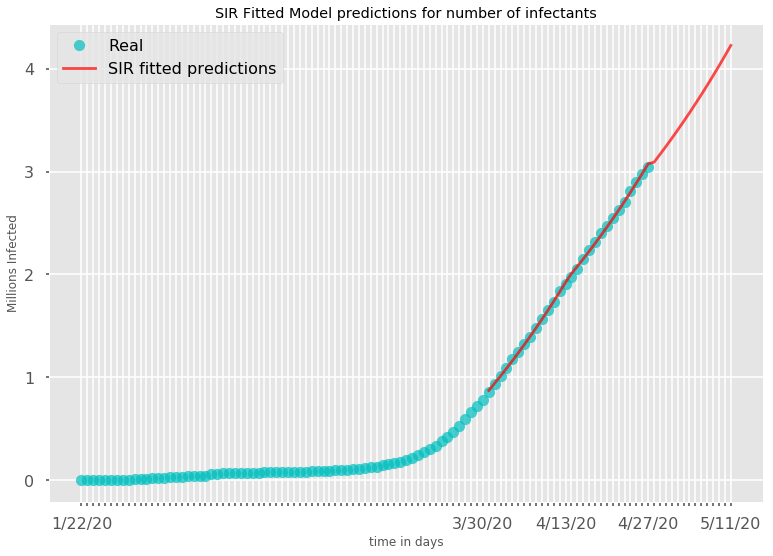

In [74]:
# plotting:
x=np.arange(1,98)
z= np.arange(70,112)
m = np.arange(1,112)
y1 = []
for i in range(2,99):
    y1.append(df_1.iloc[:,i:i+1].sum().values[0])
plt.plot(x,np.array(y1)/1000000,'o', alpha = 0.7, c = "c", label= "Real")
plt.plot(z,I_final, alpha=0.7, c="r", label= "SIR fitted predictions")

plt.xlabel("time in days")
plt.ylabel("Millions Infected")
plt.title("SIR Fitted Model predictions for number of infectants")
plt.xticks(m,Date)
plt.legend()
style.use('seaborn-poster')
style.use('ggplot')
plt.show()


# Statistical Analysis:

Now the data and the model predictions have been created, they can be analyzed. 

## Ordinary Least Squares Regression (OLS-1D) :
In order to have more accurate predictions number of infectants, the SIR model predictions were linearly regressed against the real data, y,(model calibration). Our model will be:  
$$ \hat{y}= \hat{α}+\hat{β}x$$

The assumption here is that the process that generates our data looks like:  

$$ y= α+βx+ϵ$$
where: 
- $\hat{y}$ indicates our best estimate for the fitting
- $\hat{α}$ - our estimated best intercept
- $\hat{β}$ - our estimated best slope
- x is our SIR model predictions without the fitting. 

The goal of the regression is to minimize this objective function:
$$ f(\hat{α},\hat{β})= \sum{(y_i-\hat{y_i})^2}= \sum{(y_i-\hat{α}-\hat{β}x)^2}$$

Using calculus, the minimum of this funtion was found at: 

$$ \hat{β} = \frac{\sum{(x_i-\bar{x})(y_i-\bar{y})}}{\sum{(x_i-\bar{x})^2}}$$

The intercept can be found by taking the average of the residuals:

$$ \hat{α}= \frac{1}{N} \sum{(y_i- \hat{β}x_i)}$$


The linear regression code can be found in the function regression function above.

## Linear Regression Assumption Check
One of the assumptions of linear regression is that the noise is normally distributed. 
$$ ϵ=y−α−βx ≈ y-\hat{α}-\hat{β}x= y -\hat{y} $$

This assumption can be checked by histogramming the residuals, which should be the same as looking at the ϵ distribution. This checking is done on the first two 14-days periods separately. 

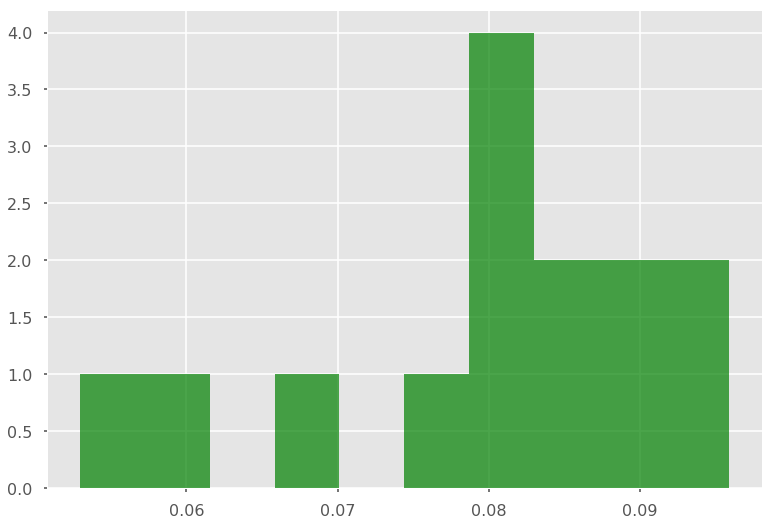

In [79]:
# Histogram of the residuals of the first 14-days period
plt.hist(np.array(y1[70:84])/1000000-Regression(70)/1000000, color= "green", alpha= 0.7)
plt.show()

Since it's not very clear if the residuals are normal, Shapiro–Wilk is used. 
## Shapiro–Wilk Test:
This test examines if the samples come from an unknown normal distribution. The null hypothsis of this test is that the samples are from the unknown parent normal distribution.

In [80]:
# Shapiro–Wilk Test for the first 14-days
print ("The p-value is ",  ss.shapiro(np.array(y1[70:84])/1000000-Regression(70)/1000000)[1]) 

The p-value is  0.13950049877166748


Since the P-value is greater than 0.05, the null hypothesis cannot be rejected. So, this proves that the residuals come from a normal distribution. 

Normality testing for the second 14-days period:

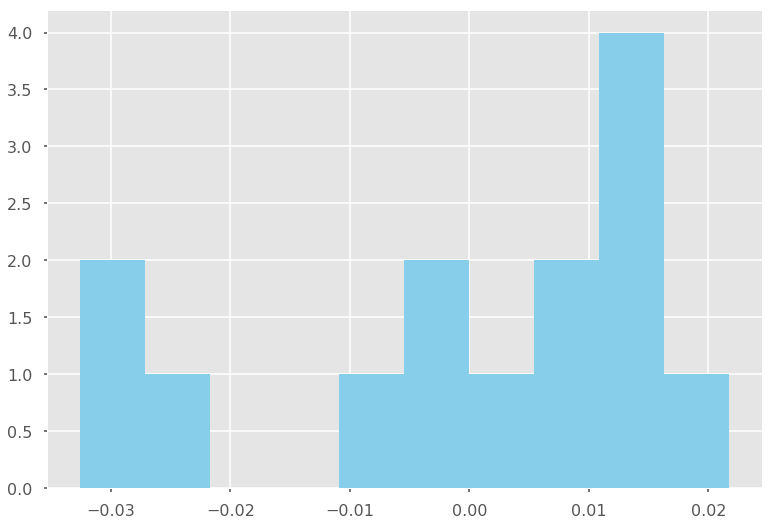

In [82]:
plt.hist(np.array(y1[83:98])/1000000-Regression(84)/1000000, color = "skyblue")
plt.show()

In [84]:
# Shapiro–Wilk Test for the second 14-days
print ("The p-value is ",  ss.shapiro(np.array(y1[70:84])/1000000-Regression(70)/1000000)[1]) 

The p-value is  0.13950049877166748


Again, since the P-value is greater than 0.05, the null hypothesis cannot be rejected. So, this proves that the residuals come from a normal distribution. 

## Standard error of residuals:
One way to asses the strength of a fit is to consider how far off the predicted value from the actual value is to calculate the standard error for the residuals. The equation that can be used is:

$$ S_ϵ^2 = \frac{1}{N-D}{\sum{(\hat{y_i}- y_i})^2}$$

Where:
- N is the number of samples
- D is the number of fit coefficients.
- The N−D term is called the degrees of freedom


Beucase some of the residuals are positive while others are negative, the sum of residuals squared is calcualted. To make the estimate unbaised, the sum of squared residuals is divided by the degrees of freedom in the model. The code for doing this calcualtion: 

In [88]:
## Sum of squared residuals
s2_epsilon = np.sum((np.array(y1[70:84])/1000000-Regression(70)/1000000)**2)/12
s2_residual = np.sqrt(s2_epsilon/12)
T = ss.t.ppf(0.975, len(x) - 2)
#print(s2_residual, T)
print("The standard error of residuals is", T * np.sqrt(s2_residual), ' with 95% confidence interval')

The standard error of residuals is 0.31493820252496124  with 95% confidence interval


# Conclusion: 

# References: 

[1] https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/  
[2] 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE
https://github.com/CSSEGISandData/COVID-19
- All other equations/information came from lecture notes/slides.
- figure(1) was created by the author of this project and wasn't obtained from an online resource